In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# !unzip data/inputs.zip
# !rm -r inputs/frame/10

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Cellular automata (not really) CNN RNN with Adaptive Computation Time (ACT)
### What I did:
* copied [this notebook](https://www.kaggle.com/teddykoker/training-cellular-automata-part-ii-learning-tasks)
* changed the model

The new model uses ACT concept from [this paper](https://arxiv.org/pdf/1603.08983.pdf). Also [this paper](https://arxiv.org/pdf/1807.03819.pdf) was useful.  
ACT replaces the original recurrency scheme.  

### Results:
* solves 26 train tasks instead of 20
* twice faster
* gifs aren't as beautiful as they were before
* actually this is not cellular automata anymore

---

In [ ]:
# !git clone https://github.com/Krzysiulek/ARC-Generator
# !python ARC-Generator/run.py

In my [previous notebook](https://www.kaggle.com/teddykoker/training-cellular-automata-part-i-game-of-life) we explored how we could use a CNN to create a cellular automata (CA) by recurrently passing the state of the grid through itself. Now we'll solve one of the tasks [arseny-n](https://www.kaggle.com/arsenynerinovsky/cellular-automata-as-a-language-for-reasoning) solved with a hard coded CA by learning the CA instead!

In [ ]:
import os
import json
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import animation, rc
from IPython.display import HTML

rc('animation', html='jshtml')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
    
def plot_pictures(pictures, labels):
    fig, axs = plt.subplots(1, len(pictures), figsize=(2*len(pictures),32))
    for i, (pict, label) in enumerate(zip(pictures, labels)):
        axs[i].imshow(np.array(pict), cmap=cmap, norm=norm)
        axs[i].set_title(label)
    plt.show()
    
def plot_sample(sample, predict=None):
    if predict is None:
        plot_pictures([sample['input'], sample['output']], ['Input', 'Output'])
    else:
        plot_pictures([sample['input'], sample['output'], predict], ['Input', 'Output', 'Predict'])
        
def inp2img(inp):
    inp = np.array(inp)
    img = np.full((10, inp.shape[0], inp.shape[1]), 0, dtype=np.uint8)
    for i in range(10):
        img[i] = (inp==i)
    return img

def input_output_shape_is_same(task):
    return all([np.array(el['input']).shape == np.array(el['output']).shape for el in task['train']])


def calk_score(task_test, predict):
    return [int(np.equal(sample['output'], pred).all()) for sample, pred in zip(task_test, predict)]

## First Task: db3e9e38

The task we'll first try is relitively straight foward; given a central orange "pillar", form stairs of alternating blue and orange in each direction. `arseny-n` showed that this could be solved with a CA consisting of three rules.

## The Model

The model consists of a single 3x3 convolutional layer, followed by a 1x1 convolutional layer, just like my last notebook. Here `num_states` represents how many values a single cell could have; in this case 10, one for each color. Down the road, we may want to add a hidden state, concatinating it to the input, then removing it from the output.

The foward pass of the model will repeatedly pass the grid state through the CA transition for `steps` number of times.

In [ ]:
HIDDEN_SIZE = 128
MAX_STEPS = 10
THRESHOLD = 0.99
REMAINDERS_PEN = 0.0

# Fix random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class CAModel(nn.Module):
    def __init__(self, num_states):
        super(CAModel, self).__init__()
        self.embedding = nn.Sequential(
            nn.Conv2d(num_states, HIDDEN_SIZE, kernel_size=1),
            nn.InstanceNorm2d(HIDDEN_SIZE),
        )
        self.transition = nn.Sequential(
            nn.InstanceNorm2d(HIDDEN_SIZE),
            nn.Conv2d(HIDDEN_SIZE, HIDDEN_SIZE, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(HIDDEN_SIZE, HIDDEN_SIZE, kernel_size=1, padding=0),
        )
        self.projection_out = nn.Conv2d(HIDDEN_SIZE, num_states, kernel_size=1)
        self.projection_halt = nn.Conv2d(HIDDEN_SIZE, 1, kernel_size=1)
        
    def forward(self, x, max_steps=None):
        x = self.embedding(x)
        # Initialize values
        halting_probability = torch.zeros([1, 1, x.shape[2], x.shape[3]], device=x.device)
        remainders = torch.zeros([1, 1, x.shape[2], x.shape[3]], device=x.device)
        n_updates = torch.zeros([1, 1, x.shape[2], x.shape[3]], device=x.device)
        # Cycle
        max_steps = max_steps or MAX_STEPS
        for i in range(max_steps):
            p = torch.sigmoid(self.projection_halt(x) - 1)
            # Formulas from https://arxiv.org/pdf/1807.03819.pdf APPENDIX C
            still_running = (halting_probability <= THRESHOLD).to(torch.float)
            new_halted = ((halting_probability + p * still_running) > THRESHOLD).to(torch.float) * still_running
            still_running = ((halting_probability + p * still_running) <= THRESHOLD).to(torch.float) * still_running
            halting_probability += p * still_running
            remainders += new_halted * (1 - halting_probability)
            halting_probability += new_halted * remainders
            n_updates += still_running + new_halted
            update_weights = p * still_running + new_halted * remainders
            # Apply transformation to the state
            transformed_state = self.transition(x)
            # Interpolate transformed and previous states for non-halted inputs
            x = transformed_state * update_weights + x * (1 - update_weights)
            # Halt
            if still_running.sum() == 0:
                break
        
        x = self.projection_out(x)
        self._remainders = remainders
        self._n_updates = n_updates
        return x

## Training

This "recurrent CNN" can be quite to difficult to train. After trying a few ideas, this seemed to be the best approach that I encountered:

* For every value $n$ = $1, ..., N$:
    1. Train the model with $n$ `steps` to produce the output from input
    2. Train the model with 1 `steps` to produce output from output
        * This enforces that the CA stabilizes after reaching a solution
        
In this way the model will try to get as close to a solution as possible in 1 step, then try to get closer in the next step, and so on until $N$ steps. For now I will use $N = 10$ = `max_steps`. I will also set the learning rate to decay with each additional step: $LR = 0.1 / (n * 2) $

In [ ]:
def solve_task(task, max_steps=10):
    model = CAModel(10).to(device)
    num_epochs = 100
    criterion = nn.CrossEntropyLoss()
    losses = np.zeros(num_epochs)
    n_updates = np.zeros(num_epochs)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for e in range(num_epochs):
        optimizer.zero_grad()
        loss = 0.0
        
        for sample in task:
            # predict output from input
            x = torch.from_numpy(inp2img(sample["input"])).unsqueeze(0).float().to(device)
            y = torch.tensor(sample["output"]).long().unsqueeze(0).to(device)
            y_pred = model(x)
            loss += criterion(y_pred, y) + (model._remainders * REMAINDERS_PEN).mean(0).sum()
            n_updates[e] += model._n_updates.detach().cpu().mean().numpy() / len(task)
        
        loss.backward()
        optimizer.step()
        losses[e] = loss.item()
    return model, losses, n_updates

@torch.no_grad()
def predict(model, task):
    predictions = []
    for sample in task:
        x = torch.from_numpy(inp2img(sample["input"])).unsqueeze(0).float().to(device)
        pred = model(x).argmax(1).squeeze().cpu().numpy()
        predictions.append(pred)
    return predictions
    
# task = train_tasks["db3e9e38"]["train"]
# model, losses, n_updates = ÷solve_task(task)

$n$ is incremented every 100 epochs, so we can see that it reaches a good solution after 3 steps (epoch 300).

Now lets see if it at least correctly outputs the training set. To be save we'll give the model $n=100$ steps:

It works! Now lets see if it generalized to the test question:

Fantastic! The coolest part now is that we can animate our solution to see the CA in action:

We can see that the CA quickly gets to a solution and then stabilizes.

## More Tasks

Now that we know we can train a CA for one task, will it work on others?

In [ ]:
def evaluate(tasks, is_test=False):
    result = []
    predictions = {}
    for idx, task in tqdm(tasks.items()):
        if input_output_shape_is_same(task):
            model, _, _ = solve_task(task["train"])
            pred = predict(model, task["test"])
            if not is_test:
                score = calk_score(task["test"], pred)
            else:
                score = [0] * len(task["test"])
        else:
            pred = [el["input"] for el in task["test"]]
            score = [0] * len(task["test"])

        predictions[idx] = pred
        result.append(score)
    return result, predictions

We solve many of the tasks within the training set using our Neural Cellular Automata model! I did test on the validation set as well, and it correctly solved 17 of the tasks. There are a number of ways this model could be improved. Please let me know if you'd be interested in collaboration!

## Solved Tasks

In [ ]:
import os
import pandas as pd

def load_data(path):
    return { task.stem: json.load(task.open()) for task in path.iterdir() if str(task).endswith(".json")}

root = "drive/MyDrive/GSN2"

scores_df = pd.DataFrame()
for task_type in os.listdir(os.path.join(root)):
    for task_size in os.listdir(os.path.join(root,task_type)):
      print(task_size)
      tasks_dir = Path(root, task_type, task_size)
      data = load_data(tasks_dir)
      data_results, data_predictions = evaluate(data)
      data_solved = [any(score) for score in data_results]
      total = sum([len(score) for score in data_results])
      solved = sum(data_solved)
      scores_df.at[task_type, task_size] = f"{solved}/{total}"
      scores_df.to_csv("drive/MyDrive/final.csv")

5


100%|██████████| 27/27 [03:11<00:00,  7.08s/it]


10


100%|██████████| 13/13 [03:20<00:00, 15.46s/it]


15


100%|██████████| 9/9 [03:42<00:00, 24.67s/it]


20


100%|██████████| 6/6 [03:09<00:00, 31.52s/it]


30


100%|██████████| 4/4 [03:13<00:00, 48.43s/it]


0it [00:00, ?it/s]

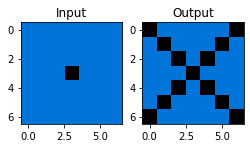

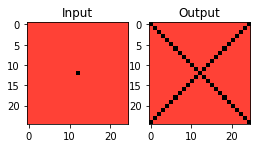

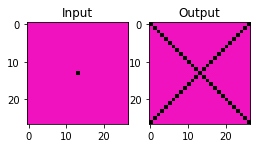

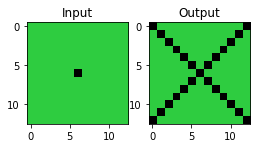

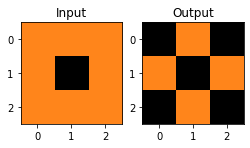

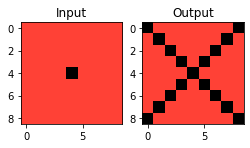

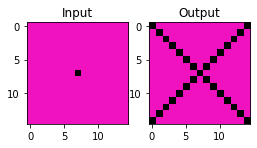

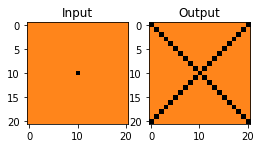

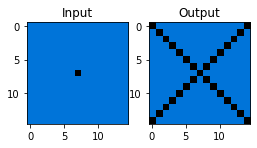

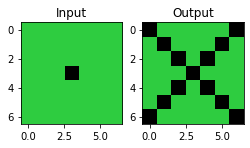

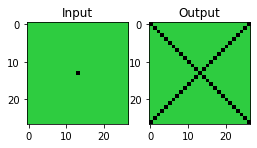

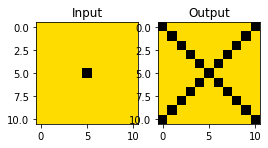

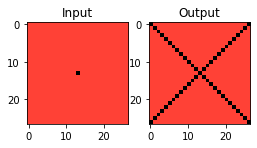

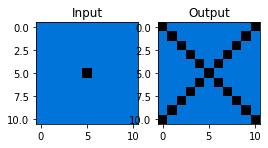

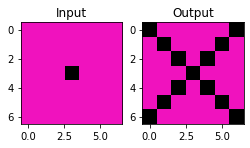

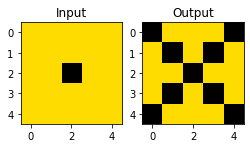

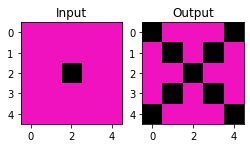

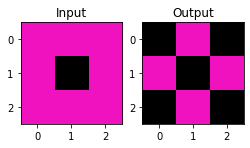

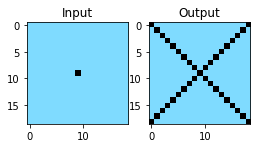

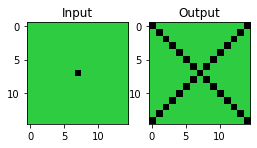

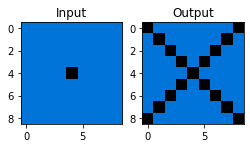

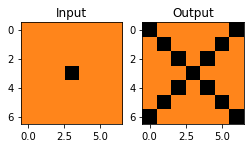

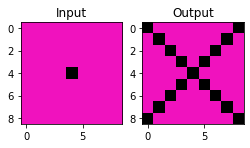

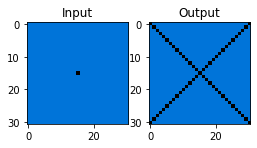

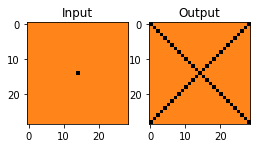

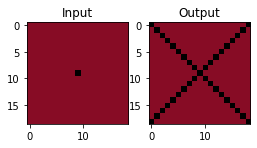

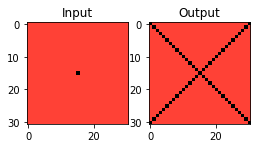

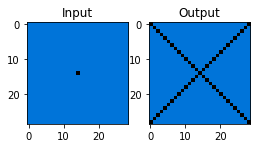

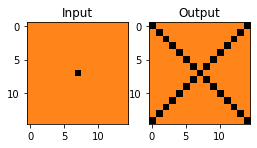

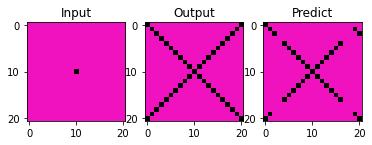

3it [00:05,  1.91s/it]

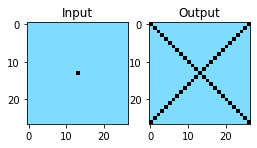

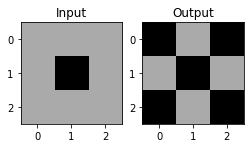

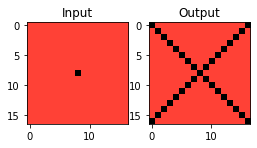

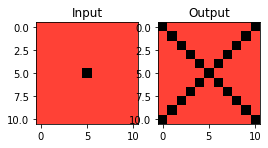

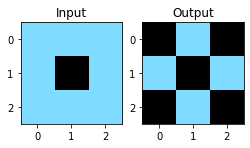

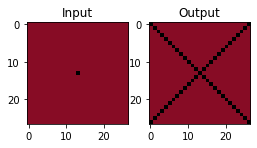

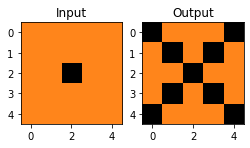

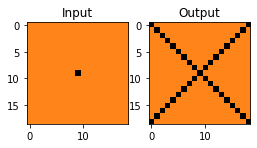

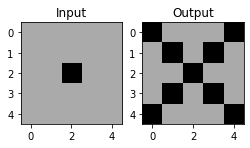

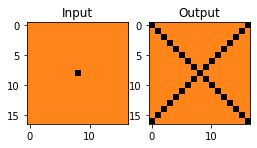

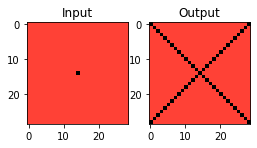

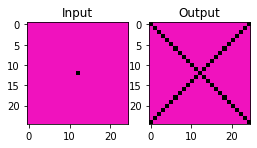

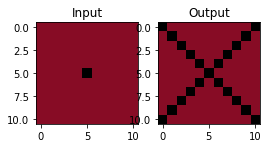

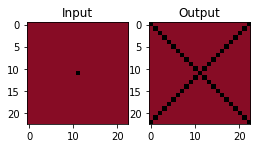

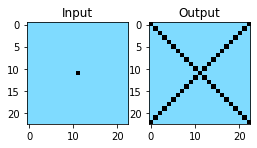

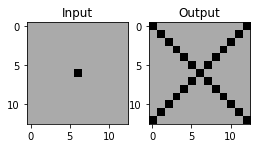

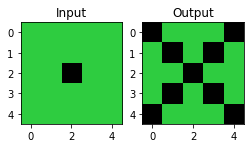

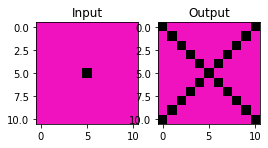

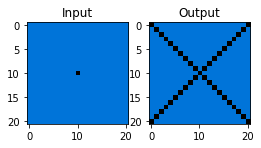

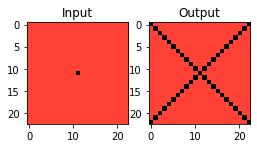

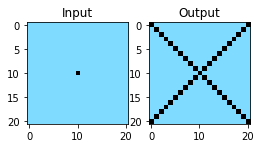

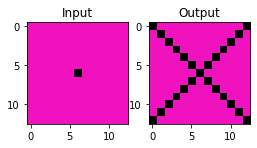

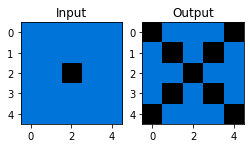

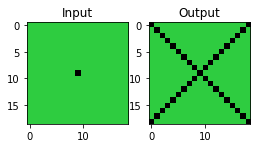

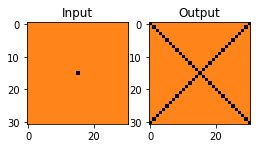

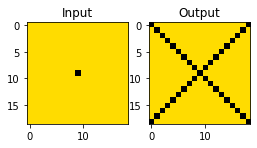

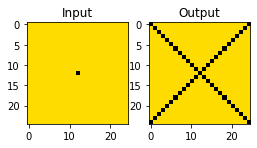

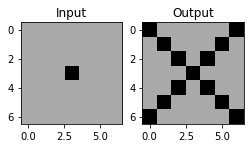

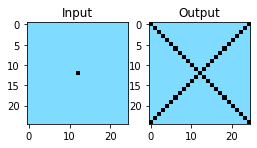

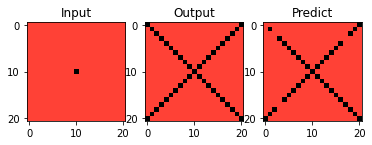

4it [00:11,  2.87s/it]


In [ ]:
for task, prediction, solved in tqdm(zip(data.values(), data_predictions.values(), data_solved)):
    if not solved:
        for i in range(len(task['train'])):
            plot_sample(task['train'][i])
            
        for i in range(len(task['test'])):
            plot_sample(task['test'][i], prediction[i])

That's all for now, thanks for reading!

# Using the correct prediction format

In [ ]:
import pandas as pd
submission = pd.read_csv(data_path / 'sample_submission.csv', index_col='output_id')
display(submission.head())

In [ ]:
def flattener(pred):
    str_pred = str([list(row) for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

In [ ]:
for output_id in submission.index:
    task_id = output_id.split('_')[0]
    pair_id = int(output_id.split('_')[1])
    f = str(test_path / str(task_id + '.json'))
    with open(f, 'r') as read_file:
        task = json.load(read_file)
    # skipping over the training examples, since this will be naive predictions
    # we will use the test input grid as the base, and make some modifications
    #data = task['test'][pair_id]['input'] # test pair input
    data = test_predictions[task_id][pair_id]
    # for the first guess, predict that output is unchanged
    pred_1 = flattener(data)
    # for the second guess, change all 0s to 5s
    data = [[5 if i==0 else i for i in j] for j in data]
    pred_2 = flattener(data)
    # for the last gues, change everything to 0
    data = [[0 for i in j] for j in data]
    pred_3 = flattener(data)
    # concatenate and add to the submission output
    pred = pred_1 + ' ' + pred_2 + ' ' + pred_3 + ' ' 
    submission.loc[output_id, 'output'] = pred

submission.to_csv('submission.csv')
submission.head()